Test Question:

Our client, a specialty oncology company, is considering entering a new therapeutic area, Glioblastoma Multiforme (GBM).  You are requested to analyze the data provided (attached GBM patient data in .csv format) and create a short report to guide a 30-minute discussion with the management team.  Our client is specifically interested in using the attached data to better understand the structure of the GBM market, i.e., identifying clinically meaningful patient sub-segments that are currently treated differently and may present distinct opportunities.

 

You can use any software package you prefer, but please convert your report to PDF before sending it to us. Additionally, please make sure that your report does not exceed 5 pages and your name is listed on top of each page.  We look forward to receiving your response. 

In [30]:
import numpy as np
import pandas as pd
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from gower import gower_matrix
import scipy.stats as stats
from scipy.stats import chi2_contingency

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [202]:
df = pd.read_csv('/Users/vishnunair/Downloads/GBM patient data.csv')
df.head()

,MD_ID,PATIENT_ID,COUNTRY,Line of therapy,Year of birth,Age at diagnosis,Gender,Race,Adequate caretaker support,Travel time to your office < 30 min,...,MGMT methylated,EGFR mutated,TP53 mutated,IDH1/IDH2 mutated,PD-L1 overexpressed,% of tumor mass surgically resected,Regimen in 1st Line,Regimen in 1st Line (Other),Regimen in 2nd Line,Regimen in 2nd Line (Other)
0,10487,104871,US,1L,1954,58,Male,Black/African,1,1,...,9,9,9,9,9,10,Avastin mono,,999,
1,10487,104872,US,1L,1947,66,Female,White/Caucasian,1,0,...,9,9,9,9,9,999,Avastin + Lomustine,,999,
2,10487,104873,US,2L,1957,56,Male,Black/African,1,1,...,9,9,9,9,9,999,Avastin + Irinotecan,,Avastin mono,
3,10487,104874,US,2L,1955,58,Female,Black/African,1,1,...,9,9,9,9,9,999,Avastin + Irinotecan,,TMZ mono,
4,10487,104875,US,2L,1946,67,Male,White/Caucasian,1,1,...,9,9,9,9,9,999,Avastin mono,,Lomustine mono,


# Exploratory Data Analysis (EDA)

First, we want to check the quality of the data. I check if there are any missing/invalid values in any of the columns and handle them accordingly. From the code below, we see that there are no null values. However, there are some columns that have '999' (in '% of tumor mass surgically resected' and 'Regimen in 2nd Line' for example) that needs to be handled. We also note the presence of '9's in the binary flag columns 'MGMT methylated', 'EGFR mutated', 'TP53 mutated', 'IDH1/IDH2 mutated', and 'PD-L1 overexpressed'. This encompasses a large amount of the dataset so we will keep it in for the analysis for the time being. This value might signify that the information is unknown, but correspondence with the individual/group who created the dataset is needed to confirm this and tweak the analysis in the future

In [136]:
#Checking shape and columns
print('Shape of dataframe:', df.shape)
print('Columns:', df.columns)

#Checking for missing values
print(df.isnull().any().any())

#Checking if there are any duplicate patient ID's
df['PATIENT_ID'].nunique()

Shape of dataframe: (750, 42)
Columns: Index(['MD_ID', 'PATIENT_ID', 'COUNTRY', 'Line of therapy', 'Year of birth',
       'Age at diagnosis', 'Gender', 'Race', 'Adequate caretaker support',
       'Travel time to your office < 30 min',
       'Patient's level of involvement in GBM', 'Patient's treatment goals',
       'Primary insurance', 'Comorbidity: Renal impairment',
       'Comorbidity: Anemia', 'Comorbidity: COPD/Pulmonary',
       'Comorbidity: Diabetes', 'Comorbidity: CHF (Cong. Heart Failure)',
       'Comorbidity: Neuropathies', 'Comorbidity: Other Neurological',
       'Comorbidity: Hepatic insufficiency', 'Comorbidity: Other cytopenia',
       'Comorbidity: Autoimmune disorder', 'Comorbidity: Hypertension',
       'Comorbidity: Other Cardiovascular', 'Comorbidity: Alzheimer's',
       'Comorbidity: Other cancer (besides GBM)',
       'Comorbidity: Other (specify)', 'Comorbidity: Other (specify).1',
       'Comorbidity: None', 'ECOG At 1st Line', 'ECOG At 2nd Line',
       

750

In [68]:
#Iterating over the columns and displaying the unique values allows us to quickly see if there are any invalid entries
for col in df.columns:
    if col != 'MD_ID' and col != 'PATIENT_ID':   
       print(col, df[col].unique())

COUNTRY ['US']
Line of therapy ['1L' '2L']
Year of birth [1954 1947 1957 1955 1946 1948 1945 1940 1965 1958 1970 1967 1950 1963
 1959 1966 1980 1960 1944 1952 1972 1935 1949 1956 1938 1932 1939 1983
 1982 1943 1951 1953 1941 1969 1979 1964 1942 1971 1962 1961 1991 1968
 1973 1975 1976 1977 1978 1937 1993 1996 1994 1992 1925 1929 1987 1981
 1936 1988 1974 1931 1933 1934 1989 1984]
Age at diagnosis [58 66 56 67 70 74 69 50 57 44 47 64 61 52 65 35 45 54 60 62 43 55 63 84
 79 59 71 77 83 75 51 49 36 37 73 72 80 48 76 78 39 53 46 68 24 40 33 34
 31 38 42 41 26 19 21 23 88 86 28 32 82 81 30]
Gender ['Male' 'Female']
Race ['Black/African' 'White/Caucasian' 'Spanish/Hispanic/Latino' 'Asian'
 'Other']
Adequate caretaker support [1 0 9]
Travel time to your office < 30 min [1 0 9]
Patient's level of involvement in GBM ['Active / knowledgeable / questioning'
 'Average level of engagement with the disease'
 'Passive / not interested / unengaged']
Patient's treatment goals ['More focused on Survival

In [22]:
#Checking for any data imbalances. It seems we there are many more males than females in the dataset. The White/Caucasian group is the majority of the dataset as well
#Perhaps GBM could be related to the race and gender variables, I will test this
print(df['Line of therapy'].value_counts())
print(df['Gender'].value_counts())
print(df['Race'].value_counts())

Line of therapy
2L    450
1L    300
Name: count, dtype: int64
Gender
Male      491
Female    259
Name: count, dtype: int64
Race
White/Caucasian            563
Black/African              110
Spanish/Hispanic/Latino     44
Asian                       30
Other                        3
Name: count, dtype: int64


# Categorical Variable Analysis

Here we conduct analysis on the categorical variables in the dataset which constitute most of the data. We use Cramer's V, which is a statistical method that allows us to find correlations between categorical variables. This in turn will allow us to choose features associated with treatment regimens when we cluster/model

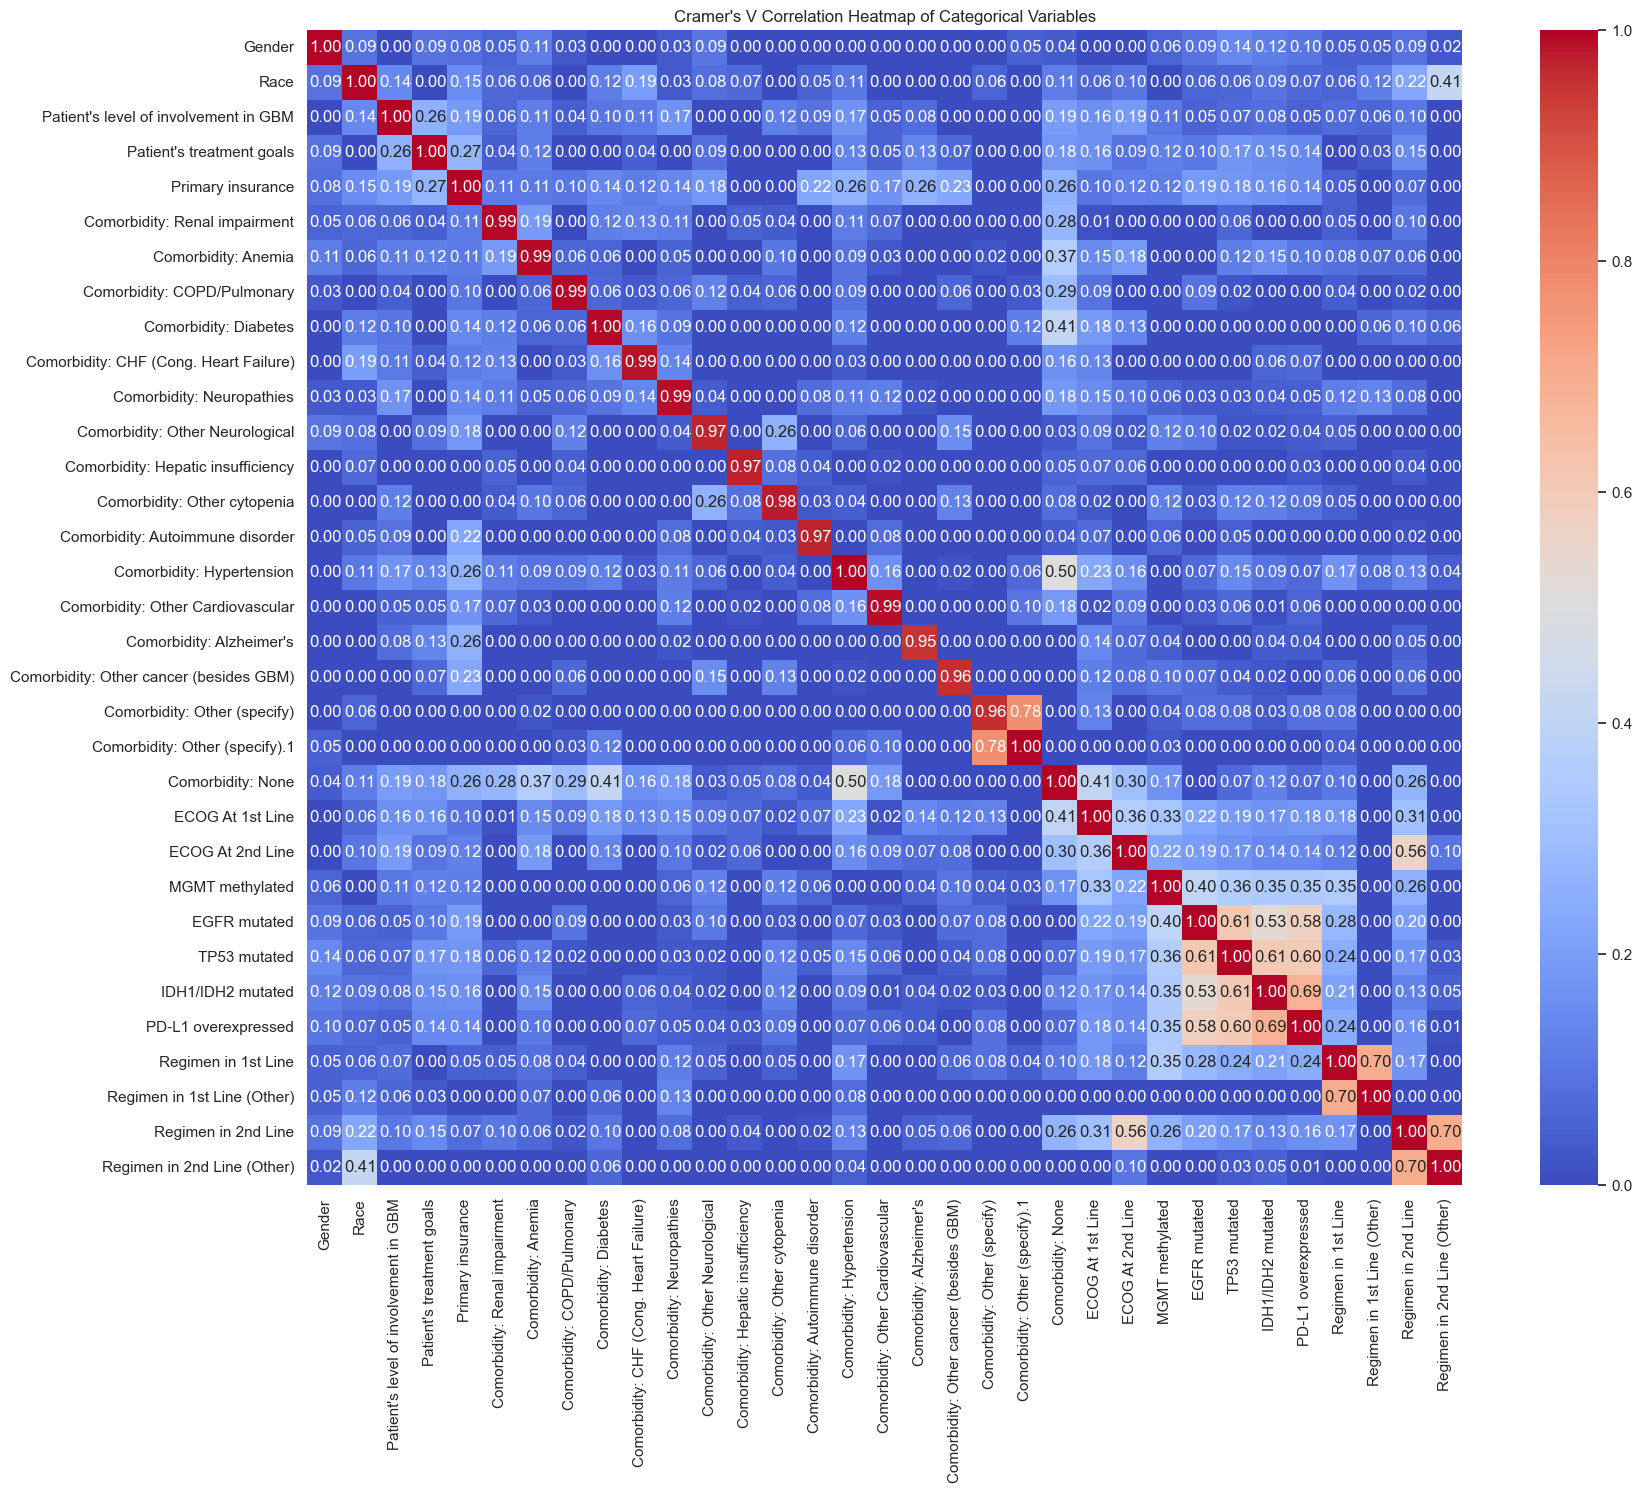

In [63]:
# Creating a Cramer's v matrix and plotting a heatmap 
cat_features = ['Gender', 'Race', "Patient's level of involvement in GBM", "Patient's treatment goals",'Primary insurance', 'Comorbidity: Renal impairment',
       'Comorbidity: Anemia', 'Comorbidity: COPD/Pulmonary',
       'Comorbidity: Diabetes', 'Comorbidity: CHF (Cong. Heart Failure)',
       'Comorbidity: Neuropathies', 'Comorbidity: Other Neurological',
       'Comorbidity: Hepatic insufficiency', 'Comorbidity: Other cytopenia',
       'Comorbidity: Autoimmune disorder', 'Comorbidity: Hypertension',
       'Comorbidity: Other Cardiovascular', "Comorbidity: Alzheimer's",
       'Comorbidity: Other cancer (besides GBM)',
       'Comorbidity: Other (specify)', 'Comorbidity: Other (specify).1',
       'Comorbidity: None', 'ECOG At 1st Line', 'ECOG At 2nd Line',
       'MGMT methylated', 'EGFR mutated', 'TP53 mutated', 'IDH1/IDH2 mutated',
       'PD-L1 overexpressed', 'Regimen in 1st Line', 'Regimen in 1st Line (Other)',
       'Regimen in 2nd Line', 'Regimen in 2nd Line (Other)']

def cramers_v_categorical(x, y):
    # Calculate observed frequencies and getting number of observations
    observed = pd.crosstab(x, y)
    n = observed.values.sum()
    # Calculate chi-square statistic and calculate Cramer's
    chi2, _, _, _ = chi2_contingency(observed)
    rows, columns = observed.shape
    phi2 = chi2 / n
    min_dim = min(rows - 1, columns - 1)
    cramers_v = np.sqrt(phi2 / min_dim)
    return cramers_v

mat_df = df[cat_features]

#Calculating Cramer's V for all pairs of categorical variables
corr_matrix = pd.DataFrame(index=mat_df.columns, columns=mat_df.columns)
for i in range(len(mat_df.columns)):
    for j in range(len(mat_df.columns)):
        corr_matrix.iloc[i, j] = cramers_v(mat_df.iloc[:, i], mat_df.iloc[:, j])

# Plot heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Cramer\'s V Correlation Heatmap of Categorical Variables')
plt.show()

In [290]:
# Define patient characteristics, perform chi-square tests and get p-values to see which variables are associated to the treatment regimen column
# Perform chi-square tests and store results
patient_characteristics = ['Gender', 'Race', 'Primary insurance', 'Comorbidity: Renal impairment', 'Comorbidity: Anemia',
       'Comorbidity: COPD/Pulmonary', 'Comorbidity: Diabetes',
       'Comorbidity: CHF (Cong. Heart Failure)', 'Comorbidity: Neuropathies',
       'Comorbidity: Other Neurological', 'Comorbidity: Hepatic insufficiency',
       'Comorbidity: Other cytopenia', 'Comorbidity: Autoimmune disorder',
       'Comorbidity: Hypertension', 'Comorbidity: Other Cardiovascular',
       "Comorbidity: Alzheimer's", 'Comorbidity: Other cancer (besides GBM)',
       'Comorbidity: Other (specify)', 'Comorbidity: Other (specify).1',
       'Comorbidity: None', 'ECOG At 1st Line', 'ECOG At 2nd Line',
       'MGMT methylated', 'EGFR mutated', 'TP53 mutated', 'IDH1/IDH2 mutated',
       'PD-L1 overexpressed']

chi2_results = {}
for characteristic in patient_characteristics:
    contingency_table = pd.crosstab(df['Regimen in 1st Line'], df[characteristic])
    chi2, p_value,x, y = stats.chi2_contingency(contingency_table)
    chi2_results[characteristic] = {'Chi-square': chi2, 'p-value': p_value}

for characteristic, result in chi2_results.items():
    print(f"Chi-square test results for {characteristic}:")
    print("Chi-square:", result['Chi-square'])
    print("p-value:", result['p-value'])
    print()

Chi-square test results for Gender:
Chi-square: 8.896524217205982
p-value: 0.26017084294726783

Chi-square test results for Race:
Chi-square: 37.70262526751341
p-value: 0.10415811522357206

Chi-square test results for Primary insurance:
Chi-square: 67.87599710067177
p-value: 0.1327640484218083

Chi-square test results for Comorbidity: Renal impairment:
Chi-square: 8.558019397985841
p-value: 0.28596393320770847

Chi-square test results for Comorbidity: Anemia:
Chi-square: 12.348979209555395
p-value: 0.08965093297760647

Chi-square test results for Comorbidity: COPD/Pulmonary:
Chi-square: 8.256391357456277
p-value: 0.31052954331990235

Chi-square test results for Comorbidity: Diabetes:
Chi-square: 6.795816164982465
p-value: 0.4504447152101744

Chi-square test results for Comorbidity: CHF (Cong. Heart Failure):
Chi-square: 3.6332473804178695
p-value: 0.8209171821777327

Chi-square test results for Comorbidity: Neuropathies:
Chi-square: 17.290639861343678
p-value: 0.015615207734845458

Chi

Now, we create some plots to get a better understanding of trends and correlations present in our dataset that will inform our clustering/machine learning algorithms

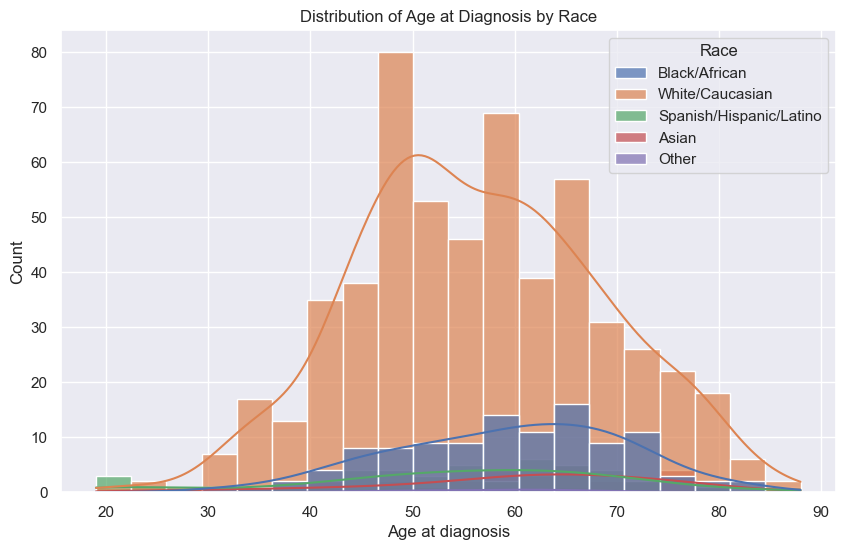

In [45]:
#KDE distribution plot of race across age of diagnosis
#It seems the dataset is mainly comprised of the White/Caucasian race, it looks approximately normally distributed in terms of age at diagnosis
#The second most common group is Black/African. Their distribution is slightly skewed left, indicating their age of diagnosis on average is slightly higher than that of the White/Caucasian group
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age at diagnosis', hue='Race', bins=20, kde=True, alpha=0.7, legend=True)
plt.title('Distribution of Age at Diagnosis by Race')
plt.show()

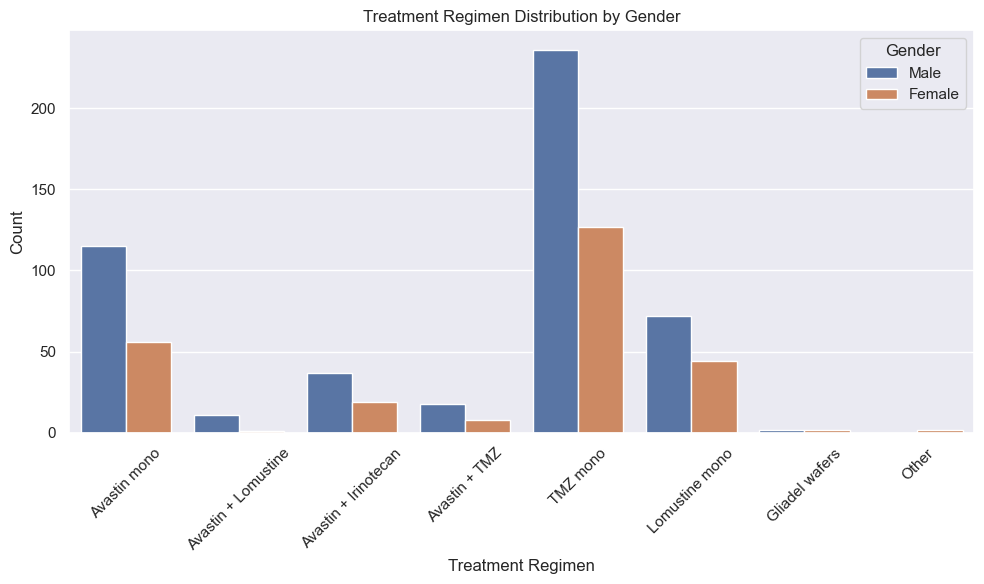

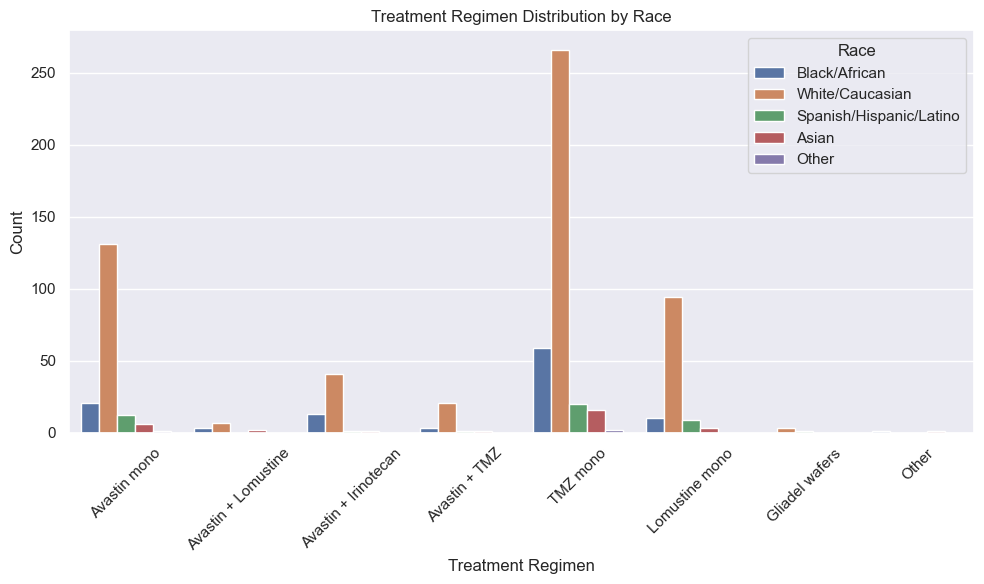

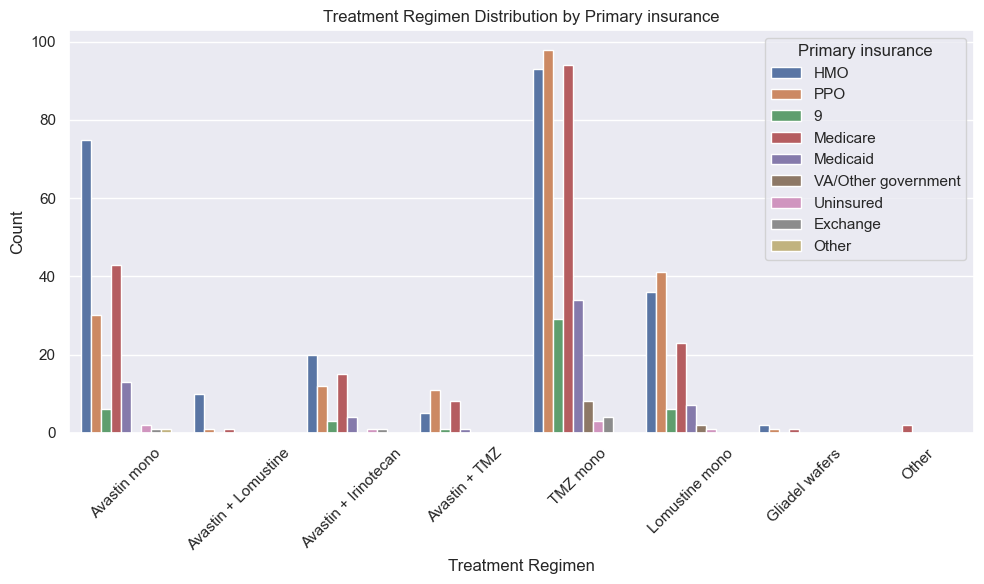

In [74]:
# Making plots for each variable get idea of how treatment regimen is distributed for each feature
patient_characteristics = ['Gender', 'Race', 'Primary insurance']
for characteristic in patient_characteristics:
    plt.figure(figsize=(10, 6))
    sns.countplot(df, x='Regimen in 1st Line', hue=characteristic)
    plt.title(f'Treatment Regimen Distribution by {characteristic}')
    plt.xlabel('Treatment Regimen')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=characteristic)
    plt.tight_layout()
    plt.show()

# Numerical Variable Analysis

In [284]:
# Creating age groups using the pd.cut() function and chi-square tests of independence for age groups and treatments
#There is a significant association between age group and treatment type
df['Age Group'] = pd.cut(df['Age at diagnosis'], bins=[20, 30, 40, 50, 60, 70, 80, 90], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90'])
chi2_age_regimen = chi2_contingency(pd.crosstab(df['Age Group'], df['Regimen in 1st Line']))
print("Chi-square test results for Age Group and Treatment Regimen:")
print("Chi-square:", chi2_age_regimen[0])
print("p-value:", chi2_age_regimen[1])

Chi-square test results for Age Group and Treatment Regimen:
Chi-square: 80.17533309233607
p-value: 0.0003518326100501747


/var/folders/zb/gnm0sh591m3345m0q3jmvw6m0000gn/T/ipykernel_70815/3222274659.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_regimen_counts_1st = df.groupby(['Age Group', 'Regimen in 1st Line']).size().unstack(fill_value=0)
/var/folders/zb/gnm0sh591m3345m0q3jmvw6m0000gn/T/ipykernel_70815/3222274659.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_regimen_counts_2nd = df.groupby(['Age Group', 'Regimen in 2nd Line']).size().unstack(fill_value=0)


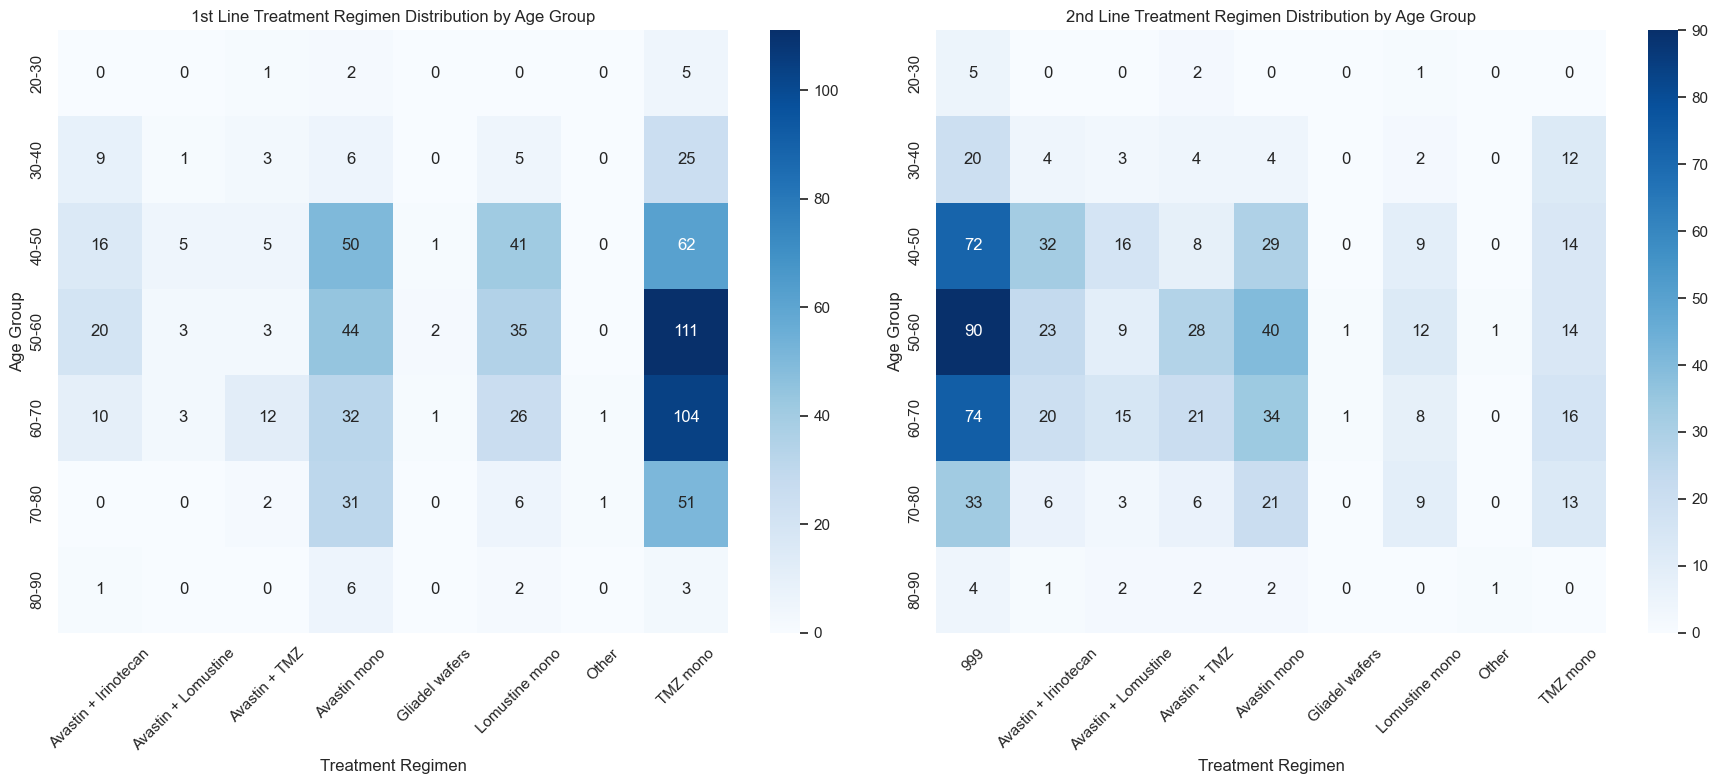

In [91]:
# Defining age bins, creating age groups, and getting the distributions of treatment regimen for each age group
age_bins = [20, 30, 40, 50, 60, 70, 80, 90]
age_labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
df['Age Group'] = pd.cut(df['Age at diagnosis'], bins=age_bins, labels=age_labels)
age_group_regimen_counts_1st = df.groupby(['Age Group', 'Regimen in 1st Line']).size().unstack(fill_value=0)
age_group_regimen_counts_2nd = df.groupby(['Age Group', 'Regimen in 2nd Line']).size().unstack(fill_value=0)


# Plotting 1st and 2nd Line Treatment Regimen Distribution by Age Group
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(age_group_regimen_counts_1st, annot=True, cmap="Blues", fmt="d", ax=axes[0])
axes[0].set_title("1st Line Treatment Regimen Distribution by Age Group")
axes[0].set_xlabel("Treatment Regimen")
axes[0].set_ylabel("Age Group")
axes[0].set_xticklabels(age_group_regimen_counts_1st.columns, rotation=45)

sns.heatmap(age_group_regimen_counts_2nd, annot=True, cmap="Blues", fmt="d", ax=axes[1])
axes[1].set_title("2nd Line Treatment Regimen Distribution by Age Group")
axes[1].set_xlabel("Treatment Regimen")
axes[1].set_ylabel("Age Group")
axes[1].set_xticklabels(age_group_regimen_counts_2nd.columns, rotation=45)

plt.tight_layout()
plt.show()

In [76]:
#Mean age of diagnosis
df['Age at diagnosis'].mean()

56.897333333333336

In [78]:
# Perform chi-square test for independence between age group and treatment regimen
#We see that age group is associated with treatment regimens
chi2, p, _, _ = chi2_contingency(age_group_regimen_counts)
print("Chi-square test results:")
print("Chi-square:", chi2)
print("p-value:", p)

Chi-square test results:
Chi-square: 80.17533309233607
p-value: 0.0003518326100501747


In [80]:
#Conducting ANOVA tests for numerical variables
#The results are both significant, we can conclude that the means between the variables differ significantly across different treatments
#Since the p-value (0.0043) is less than the typical significance level of 0.05, we reject the null hypothesis.
#This indicates that there are statistically significant differences in age at diagnosis across different treatment regimens.
#Function that performs an ANOVA test for an input variable across different groups
anova_results = f_oneway(*[group['Age at diagnosis'] for name, group in df.groupby('Regimen in 1st Line')])
print("ANOVA F-statistic:", anova_results.statistic)
print("ANOVA p-value:", anova_results.pvalue)

anova_results = f_oneway(*[group['% of tumor mass surgically resected'] for name, group in df.groupby('Regimen in 1st Line')])
print("ANOVA F-statistic:", anova_results.statistic)
print("ANOVA p-value:", anova_results.pvalue)

ANOVA F-statistic: 2.9815620187729497
ANOVA p-value: 0.0043209838640800085
ANOVA F-statistic: 19.583082133435887
ANOVA p-value: 3.8923924485548116e-24


# Significant Variable Analysis

Now that we know which variables are associated with our treatment variable, we will explore these relationships further graphically and statistically

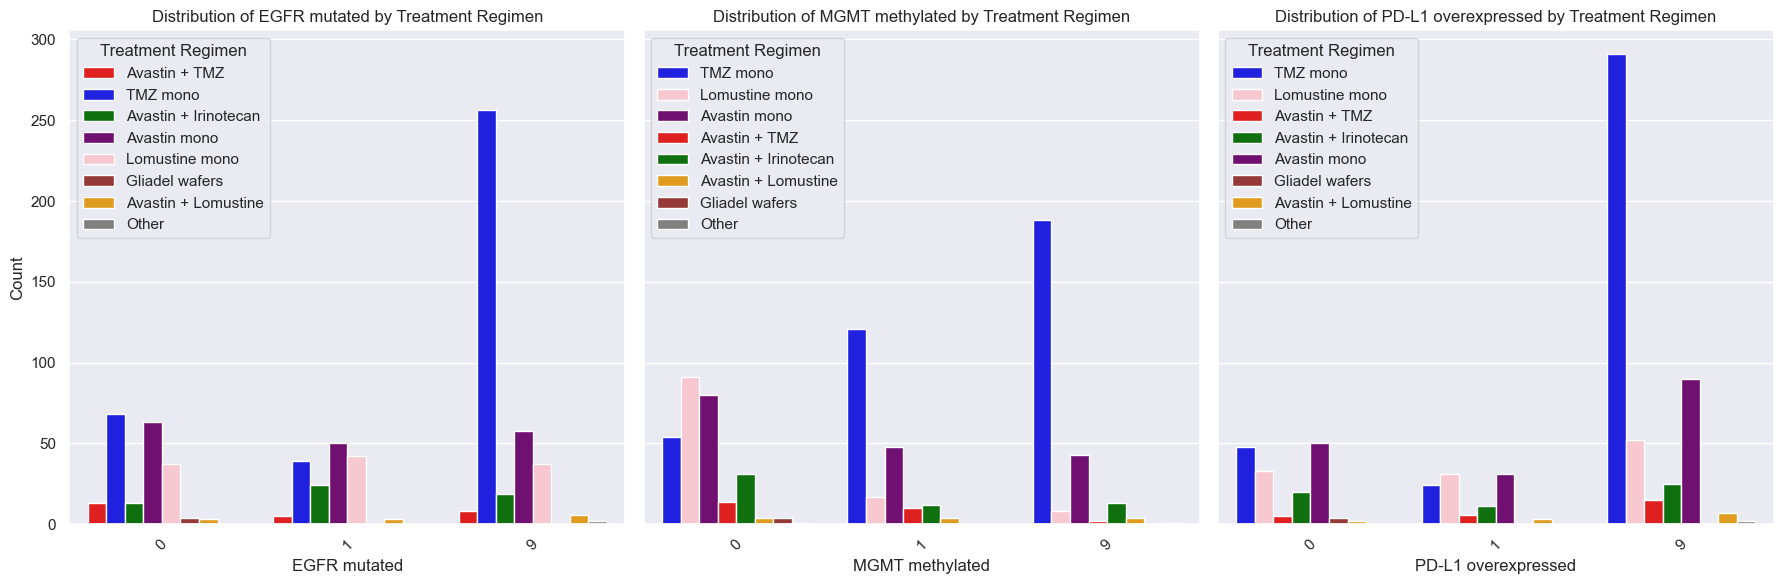

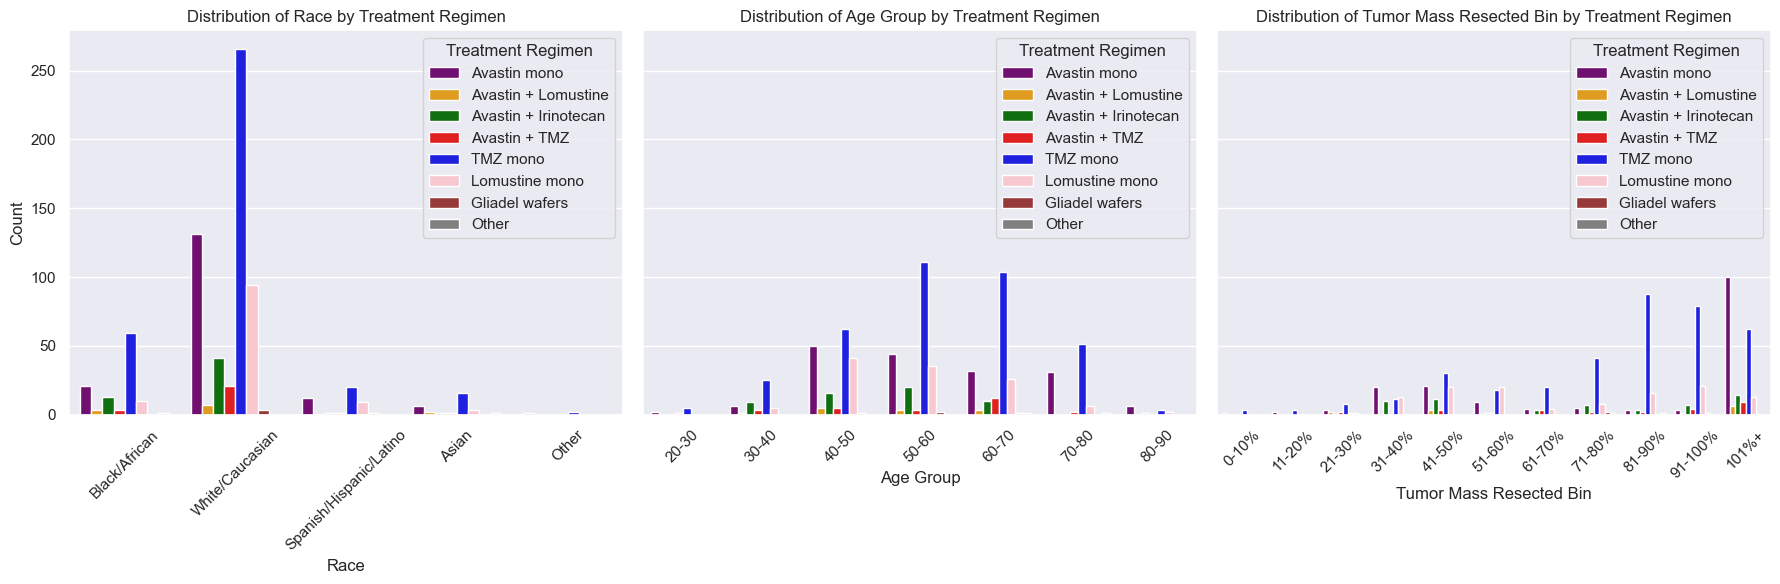

In [124]:
#These plots provide insight regarding mutations + treatment as well as race, age group, and % tumor mass resected in relation to treatment
#We will interpret these plots in the attached PDF

treatment_colors = {
    'Avastin mono': 'purple',
    'Avastin + Lomustine': 'orange',
    'Avastin + Irinotecan': 'green',
    'Avastin + TMZ': 'red',
    'TMZ mono': 'blue',
    'Lomustine mono': 'pink',
    'Gliadel wafers': 'brown',
    'Other': 'grey'
}

# Plotting gene mutations
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, gene in enumerate(['EGFR mutated', 'MGMT methylated', 'PD-L1 overexpressed']):
    sns.countplot(data=df, x=gene, hue='Regimen in 1st Line', ax=axs[i], palette=treatment_colors)
    axs[i].set_title(f'Distribution of {gene} by Treatment Regimen')
    axs[i].set_xlabel(gene)
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Treatment Regimen')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plotting other variables
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, variable in enumerate(['Race', 'Age Group', 'Tumor Mass Resected Bin']):
    sns.countplot(data=df,x=variable, hue='Regimen in 1st Line', ax=axs[i], palette=treatment_colors)
    axs[i].set_title(f'Distribution of {variable} by Treatment Regimen')
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Treatment Regimen')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<Axes: xlabel='Tumor Mass Resected Bin', ylabel='count'>

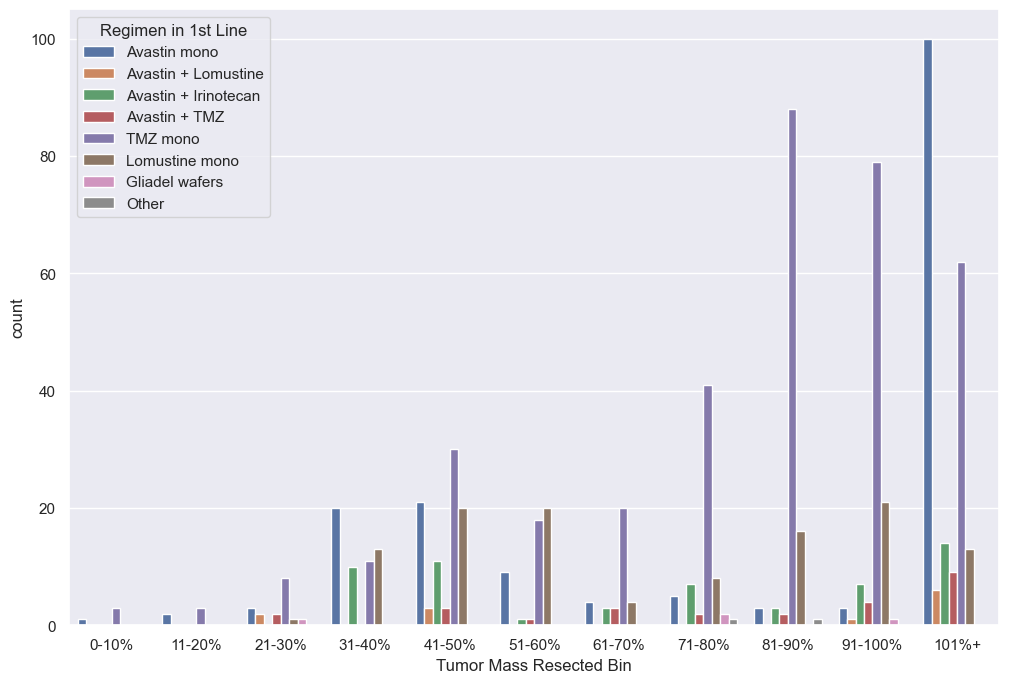

In [118]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Tumor Mass Resected Bin', hue='Regimen in 1st Line')

In [126]:
#We note that PD-L1 overexression is the most frequently occurring amongst the three categories
print(df['MGMT methylated'].value_counts())
print(df['EGFR mutated'].value_counts())
print(df['PD-L1 overexpressed'].value_counts())

MGMT methylated
0    279
9    259
1    212
Name: count, dtype: int64
EGFR mutated
9    386
0    201
1    163
Name: count, dtype: int64
PD-L1 overexpressed
9    482
0    162
1    106
Name: count, dtype: int64


In [129]:
# Get counts of MGMT methylated, EGFR mutated, and PD-L1 overexpressed by ECOG At 1st Line
mgmt_counts = df.groupby(['MGMT methylated', 'ECOG At 1st Line']).size()
print("Counts of MGMT methylated by ECOG At 1st Line:")
print(mgmt_counts)

egfr_counts = df.groupby(['EGFR mutated', 'ECOG At 1st Line']).size()
print("Counts of EGFR mutated by ECOG At 1st Line:")
print(egfr_counts)

pdl1_counts = df.groupby(['PD-L1 overexpressed', 'ECOG At 1st Line']).size()
print("Counts of PD-L1 overexpressed by ECOG At 1st Line:")
print(pdl1_counts)

Counts of MGMT methylated by ECOG At 1st Line:
MGMT methylated  ECOG At 1st Line
0                0                    60
                 1                   167
                 2                    43
                 3                     8
                 4                     1
1                0                    56
                 1                   120
                 2                    35
                 3                     1
9                0                    49
                 1                    90
                 2                    40
                 3                     4
                 4                    76
dtype: int64

Counts of EGFR mutated by ECOG At 1st Line:
EGFR mutated  ECOG At 1st Line
0             0                    47
              1                   120
              2                    30
              3                     3
              4                     1
1             0                    39
              1             

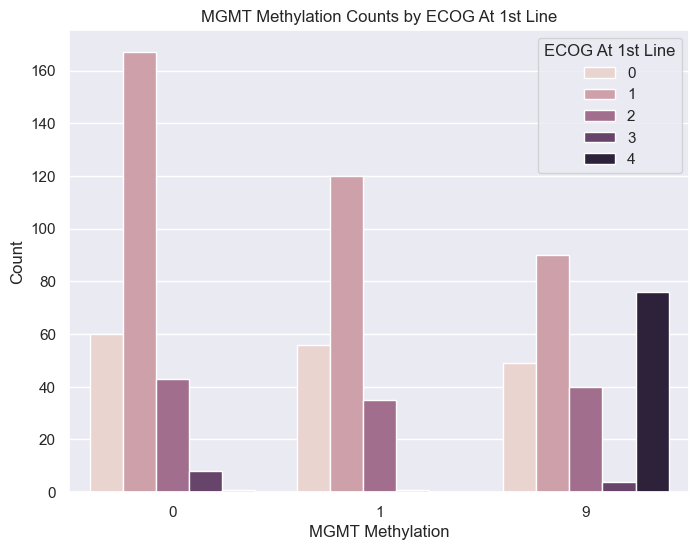

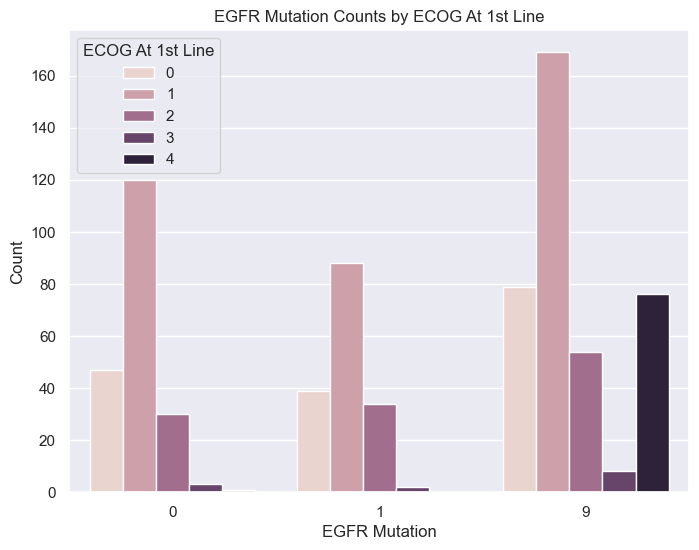

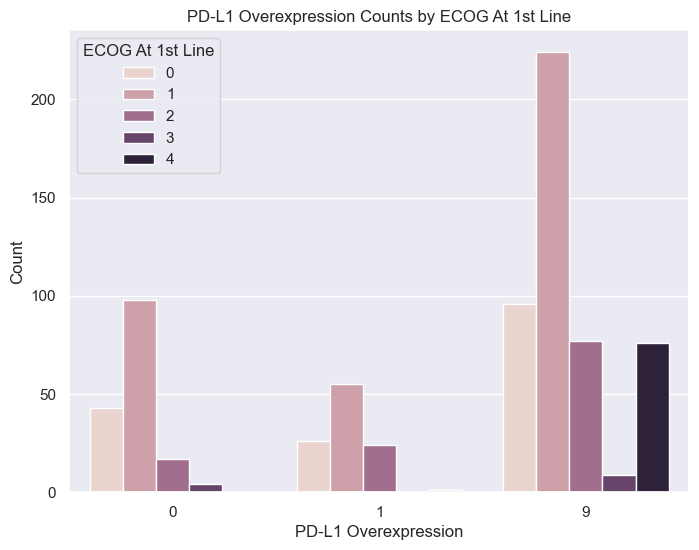

In [128]:
#Plotting counts of MGMT methylated, EGFR mutated, and PD-L1 overexpressed with ECOG at 1st line
# We note how overexpression of any of the three (equaling 9) causes high ECOG (worse quality of life) 
#More interpretation of these plots are given in the PDF
plt.figure(figsize=(8, 6))
sns.countplot(df,x='MGMT methylated', hue='ECOG At 1st Line')
plt.title('MGMT Methylation Counts by ECOG At 1st Line')
plt.xlabel('MGMT Methylation')
plt.ylabel('Count')
plt.legend(title='ECOG At 1st Line')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='EGFR mutated',hue='ECOG At 1st Line')
plt.title('EGFR Mutation Counts by ECOG At 1st Line')
plt.xlabel('EGFR Mutation')
plt.ylabel('Count')
plt.legend(title='ECOG At 1st Line')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(df, x='PD-L1 overexpressed', hue='ECOG At 1st Line')
plt.title('PD-L1 Overexpression Counts by ECOG At 1st Line')
plt.xlabel('PD-L1 Overexpression')
plt.ylabel('Count')
plt.legend(title='ECOG At 1st Line')
plt.show()

# Statistical + ML Techniques for Patient Segmentation

Here, we cluster using the K-Prototypes algorithm (which is a variant of K-Means that works for categorical and numerical variables)

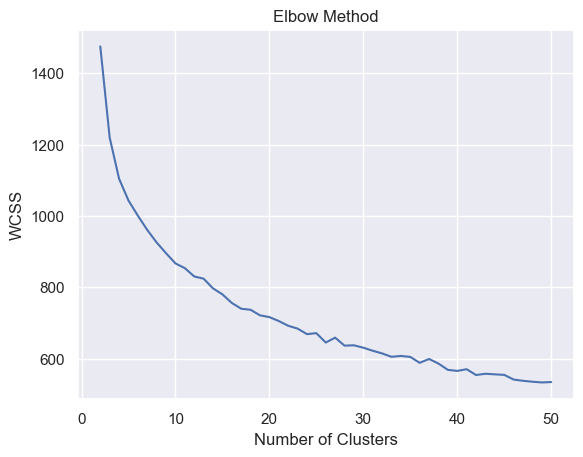

In [226]:
#Pre-processing the dataset by filtering for the significant variables we found earlier in the analysis
#Removing all invalid values in the dataset before clustering
categorical_cols = ['ECOG At 1st Line', 'MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed', 'Race', 'Regimen in 1st Line', 'Regimen in 2nd Line']
numerical_cols = ['Age at diagnosis', '% of tumor mass surgically resected']
kproto_df = df.copy()
kproto_df = kproto_df[['Age at diagnosis', 'ECOG At 1st Line', 'MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed', '% of tumor mass surgically resected', 'Race', 'Regimen in 1st Line', 'Regimen in 2nd Line']]
kproto_df = kproto_df[kproto_df['% of tumor mass surgically resected'] != 999]

# Using a label encoder for all categorical variables
label_encoders = {}
for column in categorical_cols:
    label_encoders[column] = LabelEncoder()
    kproto_df[column] = label_encoders[column].fit_transform(kproto_df[column])

#Scaling numerical variables
scaler = StandardScaler()
kproto_df[['Age at diagnosis', '% of tumor mass surgically resected']] = scaler.fit_transform(kproto_df[['Age at diagnosis', '% of tumor mass surgically resected']])

#Calculating within-cluster-sum-of-squares (WCSS) for each cluster and storing it
wcss = []
for n_clusters in range(2, 51):
    kp = KPrototypes(n_clusters=n_clusters)
    clusters = kp.fit_predict(kproto_df, categorical=[1, 2, 3, 4, 6, 7, 8])
    wcss.append(kp.cost_)

# Plotting the elbow curve
plt.plot(range(2, 51), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [302]:
#We take a cluster number that is equal to 50 since the rate of the WCSS we observe in the plot is still plateauing
# Perform clustering using k-prototypes and get summary statistics for each cluster
km = KPrototypes(n_clusters=50)
clusters = km.fit_predict(kproto_df, categorical=[1, 2, 3, 4, 6, 7, 8])
kproto_df['cluster'] = clusters
summary_stats = kproto_df.groupby('cluster').mean()
summary_stats.head()

,Age at diagnosis,ECOG At 1st Line,MGMT methylated,EGFR mutated,PD-L1 overexpressed,% of tumor mass surgically resected,Race,Regimen in 1st Line,Regimen in 2nd Line
cluster,,,,,,,,,
0,1.305529,0.875000,1.083333,1.333333,1.875,0.976899,4.000000,6.291667,1.291667
1,0.307244,0.833333,0.000000,0.166667,0.500,-1.381912,3.916667,4.583333,2.000000
2,-0.313507,0.125000,0.875000,1.000000,1.000,-0.818409,3.625000,6.000000,2.625000
3,-0.041248,0.500000,1.750000,1.000000,2.000,-2.220295,3.250000,6.000000,0.000000
4,-0.363119,1.944444,1.777778,1.944444,2.000,-0.858495,3.611111,6.166667,1.666667


In [297]:
#Appending the clusters back to the original dataframe for further aggregation
kproto_df_final = df[df['% of tumor mass surgically resected'] != 999]
kproto_df_final['cluster'] = kproto_df['cluster']
kproto_df_final = kproto_df_final[['Age at diagnosis', 'ECOG At 1st Line', 'MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed', '% of tumor mass surgically resected', 'Race', 'Regimen in 1st Line', 'Regimen in 2nd Line', 'cluster']]

/var/folders/zb/gnm0sh591m3345m0q3jmvw6m0000gn/T/ipykernel_70815/2303316279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kproto_df_final['cluster'] = kproto_df['cluster']


In [299]:
#We now aggregate based on treatment and race, finding the age range and mean age at diagnosis based on the cluster means, 
    # % tumor mass resected range and mean % resected based on cluster means, and the modes of the categorical variables
#These are the patient sub-segments we found using our K-Prototypes + aggregation approach using cluster means/modes!
patient_segments = kproto_df_final.groupby(['Regimen in 1st Line', 'Race']).agg({
    'Age at diagnosis': ['min', 'max', 'mean'],
    '% of tumor mass surgically resected': ['min', 'max', 'mean'],
    'ECOG At 1st Line': lambda x: x.mode().iloc[0],
    'MGMT methylated': lambda x: x.mode().iloc[0],
    'EGFR mutated': lambda x: x.mode().iloc[0],
    'PD-L1 overexpressed': lambda x: x.mode().iloc[0]
})
#Getting rid of formatting errors and whitespaces
patient_segments.columns = [' '.join(col).strip().replace('<lambda>', '') for col in patient_segments.columns.values]
patient_segments.columns = [col.rstrip() for col in patient_segments.columns]

#Getting the age range at diagnosis and % tumor resected range
patient_segments['Age Range'] = patient_segments['Age at diagnosis min'].astype(str) + '-' + patient_segments['Age at diagnosis max'].astype(str)
patient_segments['% of tumor resected range'] = patient_segments['% of tumor mass surgically resected min'].astype(str) + '-' + patient_segments['% of tumor mass surgically resected max'].astype(str)

#Formatting columns
patient_segments.rename(columns={'Age at diagnosis mean': 'Age at Diagnosis Mean'}, inplace=True)
patient_segments.rename(columns={'% of tumor mass surgically resected mean': '% of Tumor Mass Surgically Resected Mean'}, inplace=True)
patient_segments.reset_index(inplace=True)
print(patient_segments.columns)
patient_segments = patient_segments[['Race', 'Age Range', 'Age at Diagnosis Mean', '% of tumor resected range', '% of Tumor Mass Surgically Resected Mean', 'ECOG At 1st Line', 'MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed', 'Regimen in 1st Line']]
patient_segments

Index(['Regimen in 1st Line', 'Race', 'Age at diagnosis min',
       'Age at diagnosis max', 'Age at Diagnosis Mean',
       '% of tumor mass surgically resected min',
       '% of tumor mass surgically resected max',
       '% of Tumor Mass Surgically Resected Mean', 'ECOG At 1st Line',
       'MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed', 'Age Range',
       '% of tumor resected range'],
      dtype='object')


,Race,Age Range,Age at Diagnosis Mean,% of tumor resected range,% of Tumor Mass Surgically Resected Mean,ECOG At 1st Line,MGMT methylated,EGFR mutated,PD-L1 overexpressed,Regimen in 1st Line
0,Asian,52-52,52.000000,80-80,80.000000,1,1,9,0,Avastin + Irinotecan
1,Black/African,31-70,53.625000,34-100,59.000000,1,0,0,9,Avastin + Irinotecan
2,Spanish/Hispanic/Latino,58-58,58.000000,38-38,38.000000,1,0,1,0,Avastin + Irinotecan
3,White/Caucasian,33-70,49.656250,34-100,63.562500,1,0,1,0,Avastin + Irinotecan
4,Asian,59-63,61.000000,25-50,37.500000,1,9,9,9,Avastin + Lomustine
5,Black/African,34-34,34.000000,100-100,100.000000,2,0,1,1,Avastin + Lomustine
6,White/Caucasian,44-47,45.000000,30-46,40.666667,0,0,1,1,Avastin + Lomustine
7,Asian,75-75,75.000000,25-25,25.000000,1,1,1,1,Avastin + TMZ
8,Black/African,66-66,66.000000,50-50,50.000000,1,0,9,9,Avastin + TMZ
9,Spanish/Hispanic/Latino,55-55,55.000000,50-50,50.000000,1,1,1,9,Avastin + TMZ


# Cluster Analysis

In this section we do graphical gut checks to see how our clusters differ from one another from the K-prototypes algorithm. We just take the first 10 clusters due to ease of interpretability

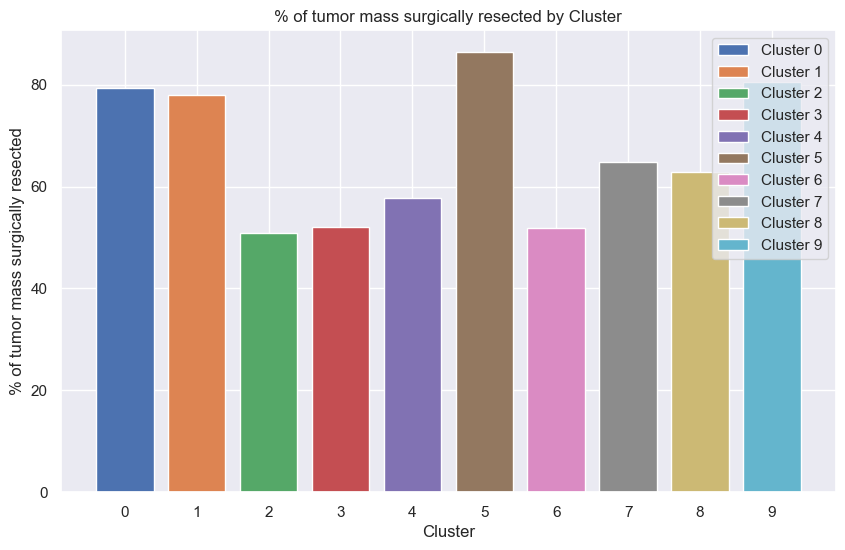

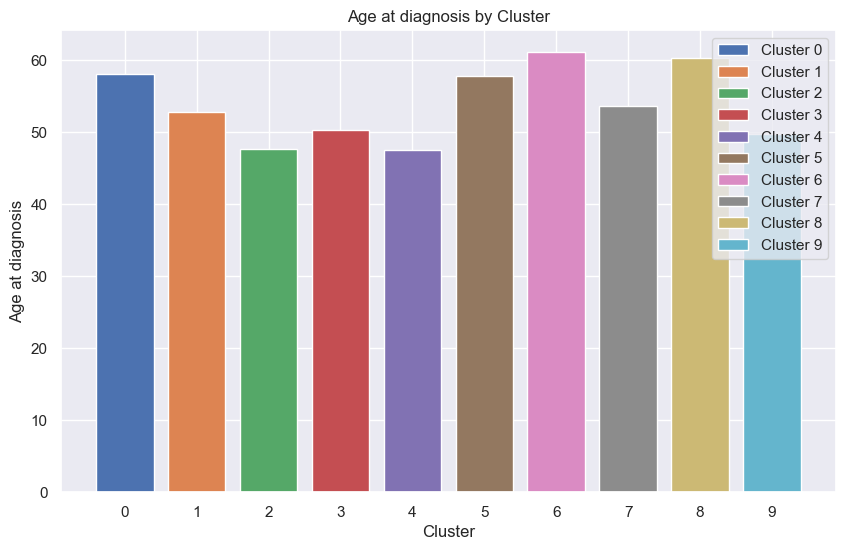

In [231]:
#We note that the clusters vary considerably for the % of tumor resected column
variables_to_plot = ['% of tumor mass surgically resected', 'Age at diagnosis']
treatments = ['Regimen in 1st Line', 'Regimen in 2nd Line']

# Plot for each variable
for variable in variables_to_plot:
    plt.figure(figsize=(10, 6))
    for cluster in range(10):
        plt.bar(cluster, summary_stats.loc[cluster, variable], label=f'Cluster {cluster}')
    
    plt.title(f'{variable} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(variable)
    plt.xticks(range(10), range(10))
    plt.legend()
    plt.grid(True)
    plt.show()

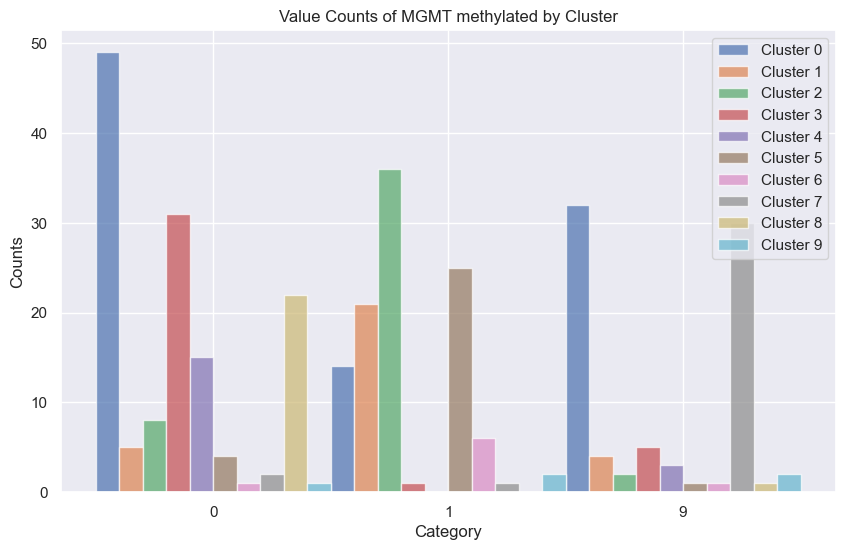

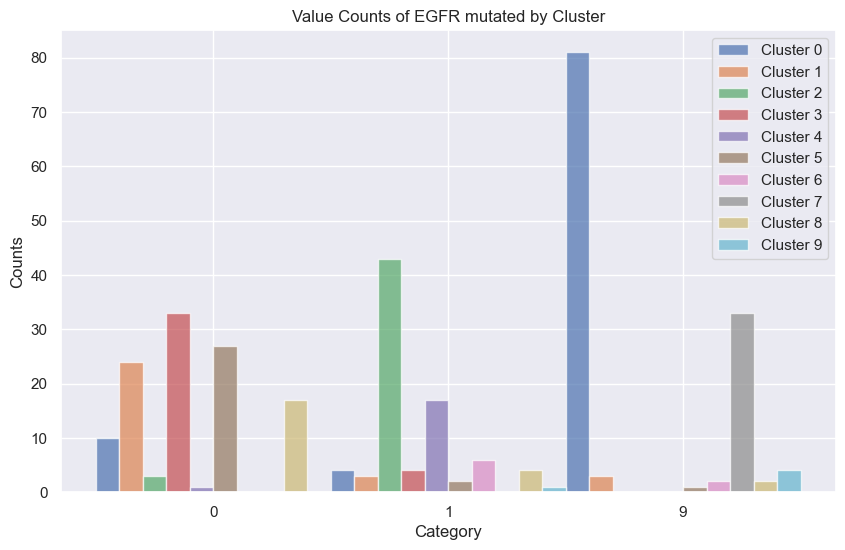

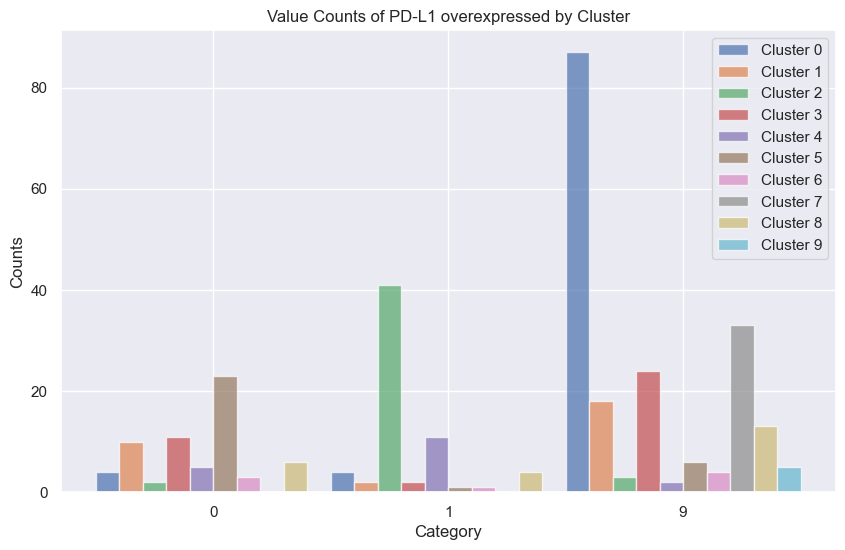

In [232]:
#The clusters vary considerably for levels of each of these mutation variables, indicating that we are able to segment efficiently

gene_mutation_variables = ['MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed']
for variable in gene_mutation_variables:
    plt.figure(figsize=(10, 6))
    cluster_counts = []
    categories = [0, 1, 9]
    for cluster in range(10):
        counts = kproto_df_final[kproto_df_final['cluster'] == cluster][variable].value_counts().sort_index()
        counts = counts.reindex([0, 1, 9], fill_value=0)
        cluster_counts.append(counts)

    cluster_counts = np.array(cluster_counts)
    x = np.arange(len(cluster_counts[0]))
    width = 0.1

    for i, counts in enumerate(cluster_counts):
        plt.bar(x + i * width, counts, width=width, label=f'Cluster {i}', alpha=0.7)

    plt.title(f'Value Counts of {variable} by Cluster')
    plt.xlabel('Category')
    plt.ylabel('Counts')
    plt.xticks(x + width * (len(cluster_counts) - 1) /2, categories)
    plt.legend()
    plt.grid(True)
    plt.show()

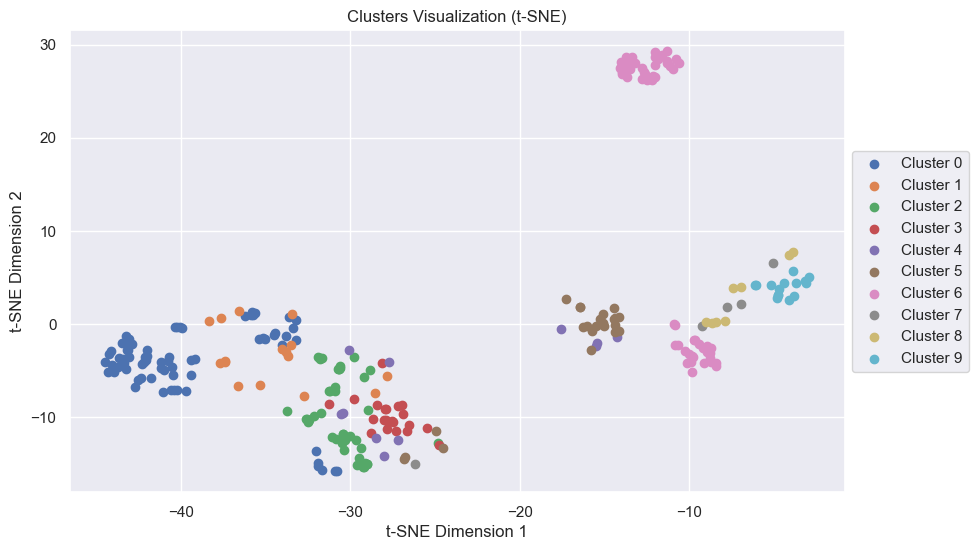

Text(0.5, 0, 't-SNE Dimension 3')

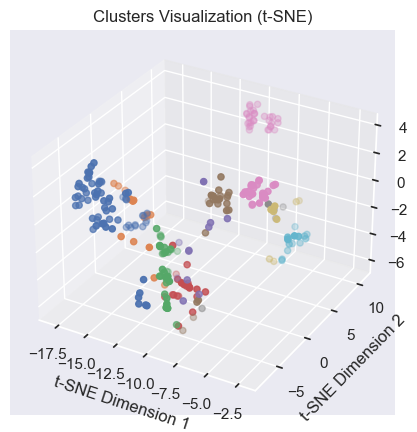

In [288]:
#We now reduce the data to 2 dimensions using t-SNE and visualize the clusters to graphically view the degree of separability
#We just take the first 10 clusters for ease of interpretability
#Reduce the data to 2 dimensions using t-SNE and plot them
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(kproto_df)
plt.figure(figsize=(10, 6))
for cluster in range(10):
    plt.scatter(tsne_result[clusters == cluster, 0], tsne_result[clusters == cluster, 1], label=f'Cluster {cluster}')

plt.title('Clusters Visualization (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

#3d plotting
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(kproto_df)

# Plot the clusters
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(10):
    ax.scatter(tsne_result[clusters == cluster, 0], tsne_result[clusters == cluster, 1], tsne_result[clusters == cluster, 2], label=f'Cluster {cluster}')

ax.set_title('Clusters Visualization (t-SNE)')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')

# Random Forest Supervised Learning Approach

To validate that these sub-segments exist and to explore the ability to predict a patient's treatment using the variables, we take a supervised learning approach. We note a 66.67% classification accuracy for the 1st line of treatment, which is a decent result considering the size of the dataset

In [287]:
#Taking a large subset of the variables (even the ones we deemed insignificant) and encoding the categorical ones
X = df[['Age at diagnosis', '% of tumor mass surgically resected', 'ECOG At 1st Line', 'ECOG At 2nd Line',
        'MGMT methylated', 'EGFR mutated', 'PD-L1 overexpressed', 'Race', 
        'Regimen in 2nd Line', 'Primary insurance', 'Comorbidity: Renal impairment',
       'Comorbidity: Anemia', 'Comorbidity: COPD/Pulmonary',
       'Comorbidity: Diabetes', 'Comorbidity: CHF (Cong. Heart Failure)',
       'Comorbidity: Neuropathies', 'Comorbidity: Other Neurological',
       'Comorbidity: Hepatic insufficiency', 'Comorbidity: Other cytopenia',
       'Comorbidity: Autoimmune disorder', 'Comorbidity: Hypertension',
       'Comorbidity: Other Cardiovascular', "Comorbidity: Alzheimer's",
       'Comorbidity: Other cancer (besides GBM)',
       'Comorbidity: Other (specify)', 'Comorbidity: Other (specify).1',
       'Comorbidity: None']]
y = df['Regimen in 1st Line']
label_encoders = {}
for column in X.select_dtypes(include='object'):
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

# Split the data into training and testing sets, fitting classifier and predict on test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666
Classification Report:
                      precision    recall  f1-score   support

Avastin + Irinotecan       0.50      0.14      0.22        14
 Avastin + Lomustine       1.00      0.25      0.40         4
       Avastin + TMZ       1.00      0.25      0.40         4
        Avastin mono       0.50      0.67      0.57        27
      Gliadel wafers       0.00      0.00      0.00         1
      Lomustine mono       0.62      0.43      0.51        30
            TMZ mono       0.75      0.93      0.83        70

            accuracy                           0.67       150
           macro avg       0.62      0.38      0.42       150
        weighted avg       0.66      0.67      0.63       150



/var/folders/zb/gnm0sh591m3345m0q3jmvw6m0000gn/T/ipykernel_70815/2785431327.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = label_encoders[column].fit_transform(X[column])
/var/folders/zb/gnm0sh591m3345m0q3jmvw6m0000gn/T/ipykernel_70815/2785431327.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = label_encoders[column].fit_transform(X[column])
/var/folders/zb/gnm0sh591m3345m0q3jmvw6m0000gn/T/ipykernel_70815/2785431327.py:24: SettingWithCopyWarning: 
A value is trying to be se

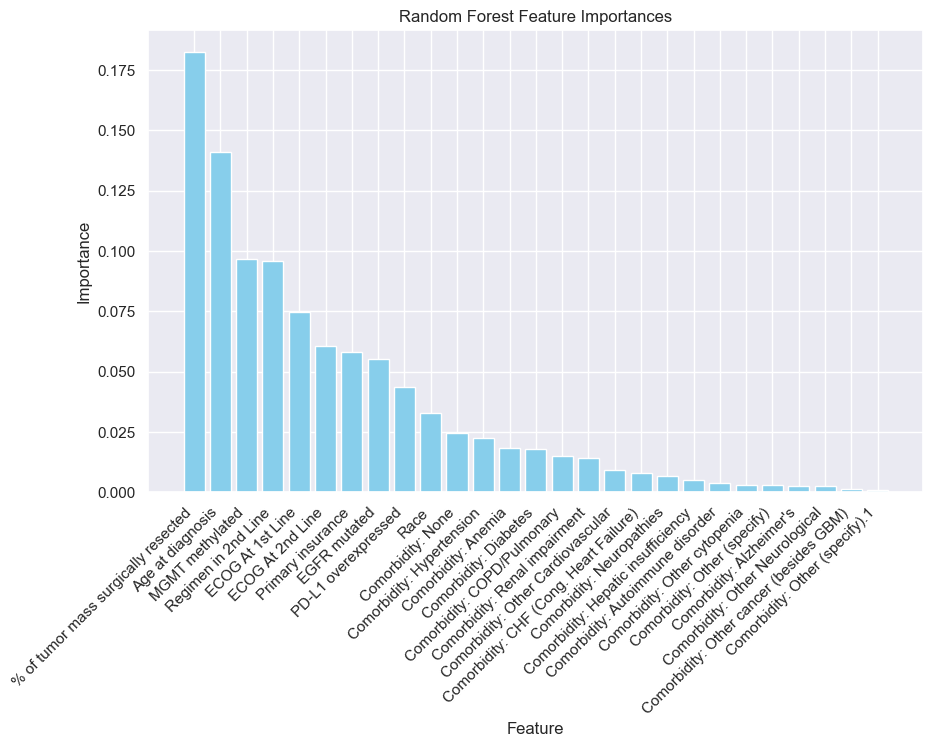

In [251]:
# Get feature importances and plot them
#As we can see, the % of tumor mass resected is the most important variable, followed by the age at diagnosis, regimen in 2nd line (which needs to be explored in future work), and ECOGs
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
feature_importances = rf_classifier.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), feature_importances[indices], color="skyblue", align="center")
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()